#ECE 595 Machine Learning II
#Project 3: GAN - Solution Code

In [2]:
#Import necessary packages
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


#Part 1: Implementing the GAN

11501568/11490434 [==============================] - 2s 0us/step


W1001 17:58:33.912502 139911984740224 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1001 17:58:33.948975 139911984740224 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1001 17:58:33.955614 139911984740224 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1001 17:58:34.122445 139911984740224 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1001 17:58:34.130909 139911984740224 deprecation_wrappe

Epoch 10000
10000: [Discriminaotr loss: 0.516465, acc: 0.456000]  [GAN loss: 1.437464, acc: 0.140000]


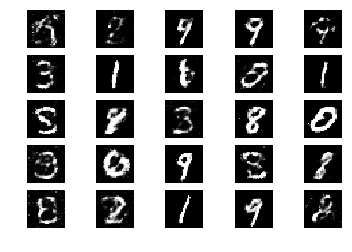

Epoch 20000
20000: [Discriminaotr loss: 0.578185, acc: 0.340000]  [GAN loss: 1.553490, acc: 0.132000]


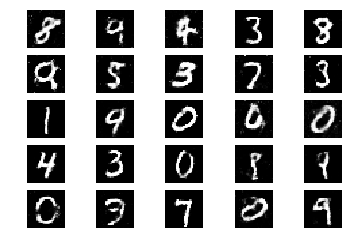

Epoch 30000
30000: [Discriminaotr loss: 0.556503, acc: 0.398000]  [GAN loss: 1.232107, acc: 0.232000]


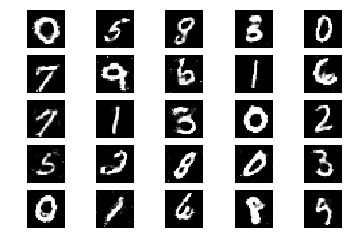

Epoch 40000
40000: [Discriminaotr loss: 0.565333, acc: 0.412000]  [GAN loss: 1.204856, acc: 0.232000]


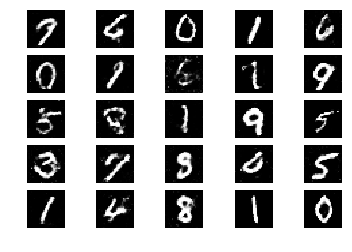

Epoch 50000
50000: [Discriminaotr loss: 0.541834, acc: 0.396000]  [GAN loss: 1.516117, acc: 0.148000]


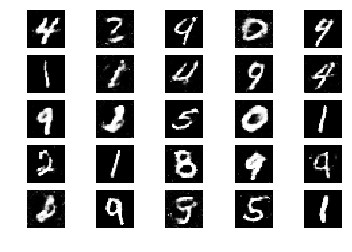

Epoch 60000
60000: [Discriminaotr loss: 0.569615, acc: 0.332000]  [GAN loss: 1.640487, acc: 0.116000]


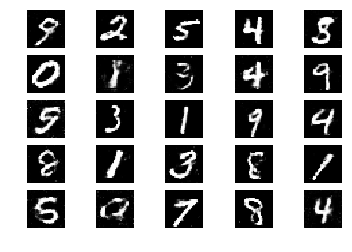

Epoch 70000
70000: [Discriminaotr loss: 0.519778, acc: 0.416000]  [GAN loss: 1.607351, acc: 0.144000]


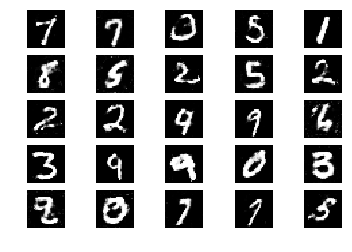

Epoch 80000
80000: [Discriminaotr loss: 0.516998, acc: 0.408000]  [GAN loss: 1.608341, acc: 0.152000]


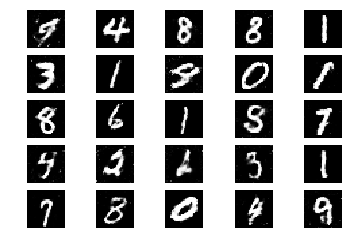

Epoch 90000
90000: [Discriminaotr loss: 0.552351, acc: 0.436000]  [GAN loss: 1.429192, acc: 0.188000]


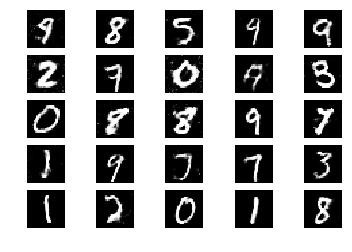

Epoch 100000
100000: [Discriminaotr loss: 0.517801, acc: 0.390000]  [GAN loss: 1.959221, acc: 0.096000]


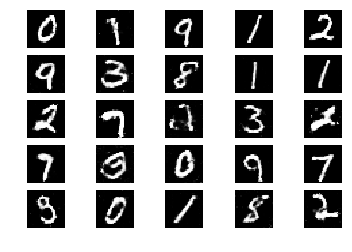

In [3]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (_, _) = mnist.load_data()
data_train = (data_train.astype(np.float32) - 127.5)/127.5
data_train = data_train.reshape(60000, 784)

# The D-dimensional noise vector length
latent_dim = 100

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)

# Genrerator model
def create_generator():
    generator=Sequential()
    generator.add(Dense(256, input_dim=latent_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(784, activation='tanh')) #tanh has range [-1, 1]

    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

# Discriminator model
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(1024, input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=1, activation='sigmoid')) #sigmoid has range [0, 1]

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
epochs = 100000
batch_size = 250
sample_interval = 10000

training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise = np.random.normal(0, 1, [batch_size, latent_dim])

    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise)

    # Get a random set of real MNIST images
    real_images = data_train[np.random.randint(low=0, high=data_train.shape[0], size=batch_size)]

    # Concatenate real and fake images into a single array (or batch)
    data_total = np.concatenate([real_images, fake_images])

    # Training labels
    labels_discriminator = np.zeros(2 * batch_size)
    labels_discriminator[:batch_size] = 0.9 # assign high probability but not 1 so that gradient does not vanish

    # Train discriminator on real and fake images
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(data_total, labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label)
    noise = np.random.normal(0, 1, [batch_size, latent_dim])
    labels_generator = np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable = False

    # Train GAN without updating discriminator weights
    gan_loss = gan.train_on_batch(noise, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
         # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
    
        #Plot 25 samples
        r, c = 5, 5
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()




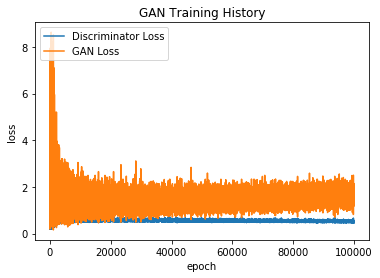

In [4]:
# Plot model loss vs epoch
plt.plot(training_meta_data[:, 0])
plt.plot(training_meta_data[:, 1])
plt.title('GAN Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Discriminator Loss', 'GAN Loss'], loc='upper left')
plt.show()

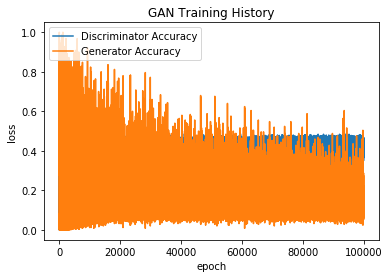

In [5]:
# Plot accuracy vs epoch
plt.plot(training_meta_data[:, 2])
plt.plot(training_meta_data[:, 3])
plt.title('GAN Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Discriminator Accuracy', 'Generator Accuracy'], loc='upper left')
plt.show()

Answer the following questions:



1.   Why does the accuracy of the discriminator remain around 50%? Is this a good trait of the GAN? 

  ANS: The accuracy remains around 50% because the generated (fake) images are mislabeled as real images in each epoch. The accuracy remaining around this value shows that the model can continue to learn to generate data more representative of the true data. Therefore, it is a good trait. If the loss were to reach 0, we would run into the vanishing gradient problem and the dicriminator would not 'learn.'


2.   How could this model be modified to produce cleaner (less noisy) images? 

  ANS: The model architecture could incorporate convolutional layers (since we are dealing with images) and we could also run the GAN for more epochs. 


#Part 2: Generating samples using trained generator

In [0]:
# Generate and save ten images
num_samples = 10
noise = np.random.normal(0, 1, [num_samples, latent_dim])
generated_images = generator.predict(noise)

# Re-scale generated images to lie in [0, 1]
generated_images = 0.5 * generated_images + 0.5

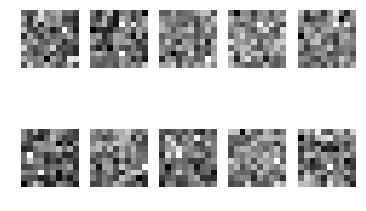

In [7]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((noise[cnt].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

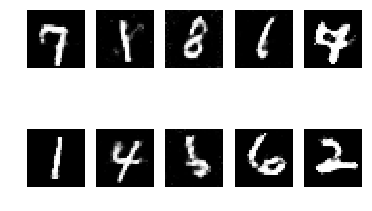

In [8]:
# Visualize generated samples
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((generated_images[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

#Part 3: Testing accuracy of generated images on ten samples

In [0]:
# Load mnist classifier and generated images
mnist_classifier = load_model('mnist_classifier.h5')

In [11]:
# Assign classes and convert to one-hot vectors 
labels = [7, 1, 8, 1, 4, 1, 4, 1, 6, 2]

# Convert integer labels to one-hot labels
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

# Show classifications
print(mnist_classifier.predict(generated_images))

# Evaluate accuracy
acc = mnist_classifier.evaluate(generated_images, labels)
print("Accuracy: %.2f%%" %(acc[1]*100))

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.51867158e-36
  7.48245904e-38 1.22480122e-36 0.00000000e+00 1.00000000e+00
  0.00000000e+00 4.46353562e-30]
 [1.54962683e-24 1.00000000e+00 1.31350441e-20 3.60687929e-18
  1.11205456e-14 1.90753469e-10 3.59663785e-21 2.84152231e-19
  5.27731281e-09 6.01988446e-20]
 [4.88070972e-18 1.71560560e-14 6.59427201e-07 1.52988253e-08
  3.57284187e-21 7.84105718e-14 3.60223313e-16 2.65034549e-20
  9.99999285e-01 1.41419999e-16]
 [5.49831936e-13 9.98944342e-01 1.67097187e-11 3.42615228e-23
  9.83003758e-15 2.52040125e-11 1.05569989e-03 2.57914274e-22
  1.13575208e-11 2.19541994e-23]
 [6.42163865e-31 3.98977212e-28 3.11721054e-28 7.81437062e-27
  6.61807554e-03 8.07846145e-28 0.00000000e+00 9.93381977e-01
  1.19440320e-25 5.71136030e-20]
 [8.15962803e-35 1.00000000e+00 1.54454975e-26 0.00000000e+00
  1.31603725e-20 9.17350525e-31 2.72094058e-28 1.13731180e-27
  2.93495956e-24 2.60990180e-37]
 [0.00000000e+00 3.05754956e-32 4.60355356e-38 0.00000000e

Answer the following questions: 



1.   State the accuracy of the classifier on your ten generated images. Based on this accuracy, would you say your generator does well in producing images comparable to those in the MNIST dataset of hand-written digits? Why or why not? 

  ANS: A high accuracy should be given (if not, the GAN was not trained properly). As a result, we can say that the generator does a good job creating MNIST-like data. 


2.   In this project, we only tested the performance of the pre-trained classifier on ten samples and used its result to determine the robustness of the generator. How could we better assess the quality of the generated images using this pre-trained classifier and the saved generator? 

  ANS: Although the literature does not state a great numerical way in measuring the robustness of a GAN, the produced data (if images) can be visually examined as was done in Part 3 of this project. Furthermore, more data could be produced and shuffled with the original data and fed to a pre-trained classifier (as we did here) so see if another model classifies GAN generated images correctly. This would quickly become tedious due to the manual inspection and labeling that would be required. 
